In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import time
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
NASDAQ100 = CONF['NASDAQ100']

pd

<module 'pandas' from 'd:\\python3\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

spider = Spider_nasdaq()
timeframe = '10y'
ignore = True

# for symbol in NASDAQ100:
for symbol in ['NDX']:
#     if symbol == 'WDAY':
#         ignore = False
#     if ignore:
#         continue
#     datafile = spider.get_stock_data(symbol, timeframe)
#     print(datafile)
    pass

Wall time: 0 ns


In [3]:
%%time

### 业务设置

start_date = '2008-06-02'
start_date = '2017-01-03'
end_date = '2018-05-01'


Wall time: 0 ns


In [4]:
%%time

stock_df_dict = {}

for symbol in NASDAQ100[:]:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
    stock_df = stock_df.loc[:, ['date', 'open', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 1.48 s ± 45.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = stock_df['date'].apply(lambda x: pd.Period(x, freq='D'))

    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 476 ms ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = pd.to_datetime(stock_df['date'])  # need .index.to_period('D')
    
    # 转换字段格式
#     stock_df = stock_df.astype(dtype={'volume': 'float64'})

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    stock_df = stock_df[::-1]
    
    # 407 µs ± 5.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     %timeit stock_df.set_index(['date'], inplace=False)

    # Wall time: 500 µs
    stock_df.set_index(['date'], inplace=True)
    
    # 305 µs ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     stock_df = stock_df.sort_index(axis=0, ascending=True)
    
    # 822 µs ± 41.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    stock_df.index = stock_df.index.to_period('D')

    # 计算涨跌幅
    stock_df['pct_change'] = stock_df.close.pct_change(1)
    
    # 减少数据
#     stock_df = stock_df['2016-01-01':]
    
    stock_df_dict[symbol] = stock_df
    
#     print(stock_df.head(10))
#     print(stock_df.dtypes)
#     print(stock_df.index[0])
#     print(type(stock_df.index[0]))

Wall time: 53.1 s


In [5]:
%%time

show_df = None
show_df = stock_df_dict['NDX'].copy()

Wall time: 1 ms


In [49]:
%%time
# %%lprun

### Turtle
TURTLE_POS = 10
TURTLE_BUY_N = 20
TURTLE_SELL_N = 5

is_happy_money = False
HAPPY_MONEY = 0
PROPERTY = 100000
CASH = 100000
hold = []
order_df = pd.DataFrame(columns=['buy_date', 'symbol', 'buy_count', 'buy_price', 'sell_date', 'sell_price', 'profit', 'cash', 'property'])
count_day = 0
yesterday = None

# show_df['CASH_T'] = pd.np.nan
# show_df['PROPERTY_T'] = pd.np.nan

rolling_min_dict = {}
rolling_max_dict = {}

for symbol in NASDAQ100:
    rolling_min_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_SELL_N).min()
    rolling_max_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_BUY_N).max()
    

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
# for today in stock_df_dict['NDX'].index:
    count_day += 1
    
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue

    if is_happy_money:        
        if PROPERTY > 100000 * 2:
            hold = []
            HAPPY_MONEY += 50000
            PROPERTY -= 50000
            CASH = PROPERTY
    
    for idx in order_df.index:
        order = order_df.iloc[idx]
        
        if order['sell_price'] != 0:
            continue
        
        is_sell = (stock_df_dict[order['symbol']].loc[today, 'open'] == rolling_min_dict[order['symbol']].loc[today])
#         is_sell = False
        
        if is_sell:
            CASH += stock_df_dict[order['symbol']].loc[today, 'open'] * order['buy_count']
            print('%s 售出 SELL %s * %d @ %f CASH=%d PROPERTY=%d' 
                  % (today, order['symbol'], order['buy_count'], stock_df_dict[order[1]].loc[today, 'open'], CASH, PROPERTY))
            order_df.loc[idx, 'sell_date'] = today
            order_df.loc[idx, 'sell_price'] = stock_df_dict[order[1]].loc[today, 'open']
            order_df.loc[idx, 'profit'] = (order_df.loc[idx, 'sell_price'] - order_df.loc[idx, 'buy_price']) * order_df.loc[idx, 'buy_count']
    
    for symbol in NASDAQ100:
        if symbol == 'NDX':
            continue
        
        if today not in stock_df_dict[symbol].index:
            continue
        
        if count_day < 20:
            is_buy = False
        else:
            is_buy = (stock_df_dict[symbol].loc[today, 'open'] == rolling_max_dict[symbol].loc[today])
#             is_buy = (stock_df_dict[symbol].loc[yesterday, 'close'] == (stock_df_dict[symbol].loc[:, 'close'].rolling(N).max()).loc[yesterday])
        
        if is_buy:
            if CASH < 100000 / TURTLE_POS:
                continue
            buy = int(100000 / TURTLE_POS / stock_df_dict[symbol].loc[today, 'open'])
            if buy == 0:
                continue
            CASH -= stock_df_dict[symbol].loc[today, 'open'] * buy
            print('%s 进场 BUY  %s * %d @ %f CASH=%d PROPERTY=%d' % 
                  (today, symbol, buy, stock_df_dict[symbol].loc[today, 'open'], CASH, PROPERTY))
            order_df = order_df.append(
                {
                    'buy_date': today,
                    'symbol': symbol,
                    'buy_count': buy,
                    'buy_price': stock_df_dict[symbol].loc[today, 'open'],
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': 0,
                    'property': 0,
                },
                ignore_index=True
            )
            
    
    show_df.loc[today, 'CASH_T'] = CASH
    PROPERTY = CASH + sum([stock_df_dict[order_df.loc[idx, 'symbol']].loc[today, 'open'] * order_df.loc[idx, 'buy_count'] for idx in order_df.loc[order_df['sell_price']==0].index])
    show_df.loc[today, 'PROPERTY_T'] = PROPERTY

    yesterday = today
            

print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)
print(hold)

s_p = stock_df_dict['NDX'].loc[start_date, 'open']
e_p = stock_df_dict['NDX'].loc[end_date, 'open']
print('NDX', s_p, e_p, e_p / s_p)


2017-01-23 进场 BUY  ADBE * 90 @ 110.710000 CASH=90036 PROPERTY=100000
2017-01-23 进场 BUY  GOOGL * 12 @ 831.610000 CASH=80056 PROPERTY=100000
2017-01-23 进场 BUY  ADSK * 122 @ 81.390000 CASH=70127 PROPERTY=100000
2017-01-23 进场 BUY  AVGO * 52 @ 191.010000 CASH=60194 PROPERTY=100000
2017-01-23 进场 BUY  CHKP * 102 @ 97.270000 CASH=50273 PROPERTY=100000
2017-01-23 进场 BUY  CMCSA * 271 @ 36.775000 CASH=40307 PROPERTY=100000
2017-01-23 进场 BUY  CSX * 223 @ 44.660000 CASH=30347 PROPERTY=100000
2017-01-23 进场 BUY  EXPE * 83 @ 120.000000 CASH=20387 PROPERTY=100000
2017-01-23 进场 BUY  FAST * 195 @ 51.210000 CASH=10401 PROPERTY=100000
2017-01-23 进场 BUY  KLAC * 122 @ 81.690000 CASH=435 PROPERTY=100000
2017-01-26 售出 SELL CHKP * 102 @ 96.600000 CASH=10289 PROPERTY=102310
2017-01-26 售出 SELL FAST * 195 @ 50.820000 CASH=20198 PROPERTY=102310
2017-01-26 进场 BUY  ATVI * 252 @ 39.680000 CASH=10199 PROPERTY=102310
2017-01-26 进场 BUY  ADBE * 87 @ 113.790000 CASH=299 PROPERTY=102310
2017-01-30 售出 SELL GOOGL * 12 @ 837.0

2017-04-04 售出 SELL MAR * 108 @ 92.670000 CASH=13317 PROPERTY=105888
2017-04-04 售出 SELL FOXA * 322 @ 32.010000 CASH=23624 PROPERTY=105888
2017-04-04 售出 SELL ATVI * 199 @ 49.370000 CASH=33449 PROPERTY=105888
2017-04-04 进场 BUY  ALGN * 85 @ 116.560000 CASH=23541 PROPERTY=105888
2017-04-04 进场 BUY  AMZN * 11 @ 891.500000 CASH=13734 PROPERTY=105888
2017-04-04 进场 BUY  CHTR * 30 @ 328.400000 CASH=3882 PROPERTY=105888
2017-04-06 售出 SELL MU * 379 @ 28.250000 CASH=14589 PROPERTY=106254
2017-04-06 进场 BUY  AMZN * 10 @ 913.800000 CASH=5451 PROPERTY=106254
2017-04-07 售出 SELL ALGN * 87 @ 114.760000 CASH=15435 PROPERTY=105682
2017-04-07 售出 SELL ALGN * 86 @ 114.760000 CASH=25305 PROPERTY=105682
2017-04-07 售出 SELL ALGN * 85 @ 114.760000 CASH=35059 PROPERTY=105682
2017-04-07 进场 BUY  CERN * 167 @ 59.530000 CASH=25118 PROPERTY=105682
2017-04-07 进场 BUY  CHTR * 29 @ 337.670000 CASH=15325 PROPERTY=105682
2017-04-07 进场 BUY  CMCSA * 261 @ 38.260000 CASH=5339 PROPERTY=105682
2017-04-11 售出 SELL CHTR * 30 @ 330.4200

2017-06-21 售出 SELL JBHT * 113 @ 87.530000 CASH=10864 PROPERTY=111631
2017-06-21 售出 SELL JBHT * 111 @ 87.530000 CASH=20580 PROPERTY=111631
2017-06-21 售出 SELL PCAR * 154 @ 63.920000 CASH=30424 PROPERTY=111631
2017-06-21 售出 SELL PCAR * 153 @ 63.920000 CASH=40204 PROPERTY=111631
2017-06-21 进场 BUY  ADBE * 68 @ 145.080000 CASH=30338 PROPERTY=111631
2017-06-21 进场 BUY  ALXN * 84 @ 118.940000 CASH=20347 PROPERTY=111631
2017-06-21 进场 BUY  AMGN * 59 @ 167.200000 CASH=10482 PROPERTY=111631
2017-06-21 进场 BUY  ADP * 96 @ 103.740000 CASH=523 PROPERTY=111631
2017-06-22 售出 SELL PAYX * 164 @ 59.870000 CASH=10342 PROPERTY=111320
2017-06-22 进场 BUY  ATVI * 164 @ 60.730000 CASH=382 PROPERTY=111320
2017-06-23 售出 SELL ADP * 96 @ 101.810000 CASH=10156 PROPERTY=114143
2017-06-23 进场 BUY  ATVI * 163 @ 61.030000 CASH=208 PROPERTY=114143
2017-06-27 售出 SELL ATVI * 164 @ 60.110000 CASH=10066 PROPERTY=114830
2017-06-27 售出 SELL ATVI * 163 @ 60.110000 CASH=19864 PROPERTY=114830
2017-06-27 进场 BUY  GILD * 140 @ 71.400000 

2017-08-15 售出 SELL ROST * 178 @ 54.670000 CASH=12740 PROPERTY=112587
2017-08-15 进场 BUY  AAPL * 62 @ 160.660000 CASH=2779 PROPERTY=112587
2017-08-18 售出 SELL ALGN * 59 @ 169.960000 CASH=12807 PROPERTY=113101
2017-08-18 售出 SELL CTSH * 140 @ 69.700000 CASH=22565 PROPERTY=113101
2017-08-18 售出 SELL ALGN * 57 @ 169.960000 CASH=32253 PROPERTY=113101
2017-08-18 售出 SELL CHTR * 24 @ 391.530000 CASH=41649 PROPERTY=113101
2017-08-18 售出 SELL CMCSA * 245 @ 40.120000 CASH=51479 PROPERTY=113101
2017-08-18 售出 SELL CTSH * 140 @ 69.700000 CASH=61237 PROPERTY=113101
2017-08-18 售出 SELL CMCSA * 241 @ 40.120000 CASH=70906 PROPERTY=113101
2017-08-18 售出 SELL MNST * 185 @ 53.480000 CASH=80800 PROPERTY=113101
2017-08-18 售出 SELL TSLA * 27 @ 352.910000 CASH=90328 PROPERTY=113101
2017-08-18 售出 SELL AAPL * 62 @ 157.860000 CASH=100115 PROPERTY=113101
2017-08-18 进场 BUY  ROST * 170 @ 58.730000 CASH=90131 PROPERTY=113101
2017-08-21 进场 BUY  ROST * 169 @ 58.950000 CASH=80169 PROPERTY=110277
2017-08-21 进场 BUY  TTWO * 108 @ 

2017-10-19 进场 BUY  IDXX * 61 @ 162.980000 CASH=45664 PROPERTY=116083
2017-10-19 进场 BUY  LRCX * 50 @ 198.390000 CASH=35744 PROPERTY=116083
2017-10-19 进场 BUY  MAR * 86 @ 115.350000 CASH=25824 PROPERTY=116083
2017-10-19 进场 BUY  VRSK * 117 @ 84.800000 CASH=15903 PROPERTY=116083
2017-10-20 进场 BUY  ADBE * 58 @ 171.500000 CASH=5956 PROPERTY=115290
2017-10-25 售出 SELL EXPE * 66 @ 148.500000 CASH=15757 PROPERTY=117066
2017-10-25 售出 SELL FAST * 206 @ 46.580000 CASH=25352 PROPERTY=117066
2017-10-25 售出 SELL HSIC * 121 @ 82.540000 CASH=35340 PROPERTY=117066
2017-10-25 售出 SELL IDXX * 61 @ 162.030000 CASH=45223 PROPERTY=117066
2017-10-25 售出 SELL VRSK * 117 @ 84.530000 CASH=55113 PROPERTY=117066
2017-10-25 进场 BUY  ADI * 111 @ 89.660000 CASH=45161 PROPERTY=117066
2017-10-25 进场 BUY  ASML * 56 @ 178.500000 CASH=35165 PROPERTY=117066
2017-10-25 进场 BUY  CSCO * 287 @ 34.730000 CASH=25198 PROPERTY=117066
2017-10-25 进场 BUY  ILMN * 46 @ 214.030000 CASH=15352 PROPERTY=117066
2017-10-25 进场 BUY  MAR * 86 @ 116.110

2017-12-21 售出 SELL COST * 59 @ 188.000000 CASH=18818 PROPERTY=120552
2017-12-21 售出 SELL COST * 58 @ 188.000000 CASH=29722 PROPERTY=120552
2017-12-21 售出 SELL PAYX * 146 @ 67.380000 CASH=39559 PROPERTY=120552
2017-12-21 进场 BUY  ALXN * 84 @ 118.320000 CASH=29620 PROPERTY=120552
2017-12-21 进场 BUY  AAL * 191 @ 52.160000 CASH=19658 PROPERTY=120552
2017-12-21 进场 BUY  ADI * 112 @ 89.000000 CASH=9690 PROPERTY=120552
2017-12-22 售出 SELL ADP * 85 @ 117.320000 CASH=19662 PROPERTY=120208
2017-12-22 售出 SELL EBAY * 272 @ 37.690000 CASH=29914 PROPERTY=120208
2017-12-22 售出 SELL EBAY * 268 @ 37.690000 CASH=40014 PROPERTY=120208
2017-12-22 售出 SELL ADP * 84 @ 117.320000 CASH=49869 PROPERTY=120208
2017-12-22 售出 SELL GOOGL * 9 @ 1070.000000 CASH=59499 PROPERTY=120208
2017-12-22 售出 SELL GOOG * 9 @ 1061.110000 CASH=69049 PROPERTY=120208
2017-12-22 进场 BUY  AAL * 189 @ 52.720000 CASH=59085 PROPERTY=120208
2017-12-22 进场 BUY  CTAS * 61 @ 162.000000 CASH=49203 PROPERTY=120208
2017-12-22 进场 BUY  CMCSA * 244 @ 40.840

2018-02-20 进场 BUY  WDAY * 80 @ 124.290000 CASH=1178 PROPERTY=120503
2018-02-22 售出 SELL CSCO * 221 @ 43.490000 CASH=10789 PROPERTY=121746
2018-02-22 售出 SELL SYMC * 360 @ 27.080000 CASH=20538 PROPERTY=121746
2018-02-22 进场 BUY  AMZN * 6 @ 1495.360000 CASH=11566 PROPERTY=121746
2018-02-22 进场 BUY  CTSH * 121 @ 82.250000 CASH=1614 PROPERTY=121746
2018-02-23 售出 SELL INTU * 58 @ 167.900000 CASH=11352 PROPERTY=121656
2018-02-23 进场 BUY  AAPL * 57 @ 173.670000 CASH=1453 PROPERTY=121656
2018-02-28 售出 SELL WDAY * 82 @ 125.200000 CASH=11719 PROPERTY=124011
2018-02-28 售出 SELL WDAY * 80 @ 125.200000 CASH=21735 PROPERTY=124011
2018-02-28 售出 SELL WDAY * 80 @ 125.200000 CASH=31751 PROPERTY=124011
2018-02-28 进场 BUY  ADI * 105 @ 94.500000 CASH=21829 PROPERTY=124011
2018-02-28 进场 BUY  AAPL * 55 @ 179.260000 CASH=11969 PROPERTY=124011
2018-02-28 进场 BUY  ADSK * 85 @ 117.020000 CASH=2023 PROPERTY=124011
2018-03-01 售出 SELL CTSH * 124 @ 82.240000 CASH=12220 PROPERTY=123199
2018-03-01 售出 SELL CTSH * 122 @ 82.2400

2018-04-23 进场 BUY  ULTA * 42 @ 236.190000 CASH=9357 PROPERTY=117668
2018-04-24 售出 SELL GOOGL * 9 @ 1059.200000 CASH=18890 PROPERTY=117977
2018-04-24 售出 SELL GOOG * 9 @ 1052.000000 CASH=28358 PROPERTY=117977
2018-04-24 进场 BUY  CDNS * 249 @ 40.110000 CASH=18371 PROPERTY=117977
2018-04-24 进场 BUY  CTAS * 57 @ 174.500000 CASH=8424 PROPERTY=117977
2018-04-25 售出 SELL VRSK * 93 @ 106.820000 CASH=18358 PROPERTY=118059
2018-04-25 售出 SELL CTXS * 104 @ 96.680000 CASH=28413 PROPERTY=118059
2018-04-25 售出 SELL BKNG * 4 @ 2061.120000 CASH=36658 PROPERTY=118059
2018-04-25 售出 SELL CTXS * 102 @ 96.680000 CASH=46519 PROPERTY=118059
2018-04-25 售出 SELL CERN * 168 @ 57.750000 CASH=56221 PROPERTY=118059
2018-04-25 售出 SELL CTAS * 57 @ 171.090000 CASH=65973 PROPERTY=118059
2018-04-25 进场 BUY  HSIC * 135 @ 73.650000 CASH=56030 PROPERTY=118059
2018-04-25 进场 BUY  ILMN * 39 @ 251.990000 CASH=46203 PROPERTY=118059
2018-04-25 进场 BUY  LBTYA * 302 @ 33.010000 CASH=36234 PROPERTY=118059
2018-04-26 售出 SELL ILMN * 39 @ 232

In [51]:
sum(list(order_df['profit']))
# [order_df.loc[idx, 'buy_count'] for idx in order_df.loc[order_df['sell_price']==0].index]
# sum([stock_df_dict[order_df.loc[idx, 'symbol']].loc[today, 'open'] * order_df.loc[idx, 'buy_count'] for idx in order_df.loc[order_df['sell_price']==0].index])
order_df
# order_df.loc[order_df['sell_price']==0]

14296.083399999976

,buy_date,symbol,buy_count,buy_price,sell_date,sell_price,profit,cash,property
0,2017-01-23,ADBE,90,110.710,2017-02-02,112.82,189.9,0,0
1,2017-01-23,GOOGL,12,831.610,2017-01-30,837.06,65.4,0,0
2,2017-01-23,ADSK,122,81.390,2017-01-30,81.57,21.96,0,0
3,2017-01-23,AVGO,52,191.010,2017-02-01,202.25,584.48,0,0
4,2017-01-23,CHKP,102,97.270,2017-01-26,96.6,-68.34,0,0
5,2017-01-23,CMCSA,271,36.775,2017-02-07,37.33,150.405,0,0
6,2017-01-23,CSX,223,44.660,2017-01-31,46.97,515.13,0,0
7,2017-01-23,EXPE,83,120.000,2017-02-02,120.45,37.35,0,0
8,2017-01-23,FAST,195,51.210,2017-01-26,50.82,-76.05,0,0
9,2017-01-23,KLAC,122,81.690,2017-02-09,86.85,629.52,0,0


In [7]:
%%time
# %%lprun

### Turtle
TURTLE_POS = 20
TURTLE_BUY_N = 20
TURTLE_SELL_N = 10

is_happy_money = False
HAPPY_MONEY = 0
PROPERTY = 100000
CASH = 100000
hold = []
record_df = pd.DataFrame(columns=['date', 'ops', 'reason', 'symbol', 'count', 'price', 'buy_price', 'expect', 'profit', 'cash', 'property'])
# record_df = pd.DataFrame(columns=['buy_date', 'symbol', 'buy_count', 'buy_price', 'sell_date', 'sell_price', 'profit', 'cash', 'property'])
count_day = 0
yesterday = None

show_df['CASH_T'] = pd.np.nan
show_df['PROPERTY_T'] = pd.np.nan

rolling_min_dict = {}
rolling_max_dict = {}

for symbol in NASDAQ100:
    rolling_min_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_SELL_N).min()
    rolling_max_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_BUY_N).max()
    

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
# for today in stock_df_dict['NDX'].index:
    count_day += 1
    
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue

    if is_happy_money:        
        if PROPERTY > 100000 * 2:
            hold = []
            HAPPY_MONEY += 50000
            PROPERTY -= 50000
            CASH = PROPERTY
        
#     show_df.loc[today, 'CASH_T'] = CASH
#     PROPERTY = CASH + sum([stock_df_dict[order[1]].loc[yesterday, 'close'] * order[2] for order in hold])
#     show_df.loc[today, 'PROPERTY_T'] = PROPERTY

    for order in hold:
        is_sell = (stock_df_dict[order[1]].loc[today, 'open'] == rolling_min_dict[order[1]].loc[today])
        
        if is_sell:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'open'] * order[2]
#             print('%s 售出 SELL %s * %d @ %f CASH=%d PROPERTY=%d' 
#                   % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close'], CASH, PROPERTY))
            record_df = record_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'WIN',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'open'],
                    'buy_price': order[3],
                    # 'expect': order[4],
                    'expect': 0,
                    'profit': (stock_df_dict[order[1]].loc[today, 'open'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    for symbol in NASDAQ100:
        if symbol == 'NDX':
            continue
        
        if today not in stock_df_dict[symbol].index:
            continue
        
        if count_day < 20:
            is_buy = False
        else:
            is_buy = (stock_df_dict[symbol].loc[today, 'open'] == rolling_max_dict[symbol].loc[today])
#             is_buy = (stock_df_dict[symbol].loc[yesterday, 'close'] == (stock_df_dict[symbol].loc[:, 'close'].rolling(N).max()).loc[yesterday])
        
        if is_buy:
            if CASH < PROPERTY / TURTLE_POS:
                continue
            buy = int(PROPERTY / TURTLE_POS / stock_df_dict[symbol].loc[today, 'open'])
#             buy = int(CASH / TURTLE_POS / stock_df_dict[symbol].loc[today, 'open'])
            if buy == 0:
                continue
            CASH -= stock_df_dict[symbol].loc[today, 'open'] * buy
#             CASH -= stock_df_dict[symbol].loc[today, 'open'] * buy
            hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'open'], 0])
#             print('%s 进场 BUY  %s * %d @ %f CASH=%d PROPERTY=%d' % 
#                   (today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], CASH, PROPERTY))
            record_df = record_df.append(
                {
                    'date': today,
                    'ops': 'BUY',
                    'reason': 'ENTER',
                    'symbol': symbol,
                    'count': buy,
                    'price': stock_df_dict[symbol].loc[today, 'open'],
                    'buy_price': stock_df_dict[symbol].loc[today, 'open'],
                    # 'expect': stock_df_dict[symbol].loc[yesterday, 'close'],
                    'expect': 0,
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    show_df.loc[today, 'CASH_T'] = CASH
    PROPERTY = CASH + sum([stock_df_dict[order[1]].loc[today, 'open'] * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY_T'] = PROPERTY

    yesterday = today
            

print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)
print(hold)

s_p = stock_df_dict['NDX'].loc[start_date, 'open']
e_p = stock_df_dict['NDX'].loc[end_date, 'open']
print('NDX', s_p, e_p, e_p / s_p)


23512.35
0
120653.81
[[Period('2018-04-05', 'D'), 'HSIC', 86, 68.75, 0], [Period('2018-04-05', 'D'), 'ROST', 75, 78.890000000000001, 0], [Period('2018-04-06', 'D'), 'ROST', 75, 79.200000000000003, 0], [Period('2018-04-12', 'D'), 'HSIC', 86, 69.359999999999999, 0], [Period('2018-04-13', 'D'), 'COST', 31, 189.81, 0], [Period('2018-04-13', 'D'), 'HSIC', 85, 69.980000000000004, 0], [Period('2018-04-23', 'D'), 'CERN', 101, 59.399999999999999, 0], [Period('2018-04-23', 'D'), 'HSIC', 83, 72.019999999999996, 0], [Period('2018-04-23', 'D'), 'ULTA', 25, 236.19, 0], [Period('2018-04-24', 'D'), 'CDNS', 150, 40.109999999999999, 0], [Period('2018-04-25', 'D'), 'HSIC', 82, 73.650000000000006, 0], [Period('2018-04-26', 'D'), 'CTXS', 59, 102.2, 0], [Period('2018-04-27', 'D'), 'ALXN', 50, 120.64, 0], [Period('2018-04-27', 'D'), 'AMZN', 3, 1634.01, 0], [Period('2018-05-01', 'D'), 'CTXS', 58, 104.70999999999999, 0], [Period('2018-05-01', 'D'), 'ULTA', 24, 252.06, 0]]
NDX 4900.854 6592.927 1.34526084637
Wa

In [8]:
for symbol, stock_df in stock_df_dict.items():
    df = stock_df.loc[start_date:end_date, 'close']
#     print(df)
    s_p = df.head(1).values
    e_p = df.tail(1).values
#     print(symbol, s_p, e_p, e_p / s_p)


In [9]:
# pd.set_option('display.max_rows', 1000)
# record_df
# record_df.loc[record_df['ops']=='SELL'].sort_values(by=['profit'])

,date,ops,reason,symbol,count,price,buy_price,expect,profit,cash,property
503,2018-02-08,SELL,WIN,TTWO,50,112.0000,126.8500,0,-742.5,70570.7450,119069
414,2017-12-21,SELL,WIN,ALGN,24,234.2900,264.4000,0,-722.64,24994.3550,124792
421,2017-12-22,SELL,WIN,ALGN,25,216.3700,245.0000,0,-715.75,5819.1650,124442
509,2018-02-12,SELL,WIN,CHTR,16,350.2600,391.6000,0,-661.44,93163.8750,116961
391,2017-11-29,SELL,WIN,ADSK,49,114.0300,127.5100,0,-660.52,8510.8450,129905
407,2017-12-05,SELL,WIN,ALGN,24,225.0200,252.2400,0,-653.28,31686.4450,129084
506,2018-02-09,SELL,WIN,CTAS,37,150.8100,167.8700,0,-631.22,75914.5350,118206
504,2018-02-08,SELL,WIN,IDXX,32,175.7000,193.5300,0,-570.56,76193.1450,119069
370,2017-11-07,SELL,WIN,ATVI,93,61.0900,66.8700,0,-537.54,14864.9950,126746
257,2017-08-10,SELL,WIN,ADP,49,108.8000,118.7900,0,-489.51,19101.0650,115379


In [10]:
%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = record_df.loc[record_df['ops']=='SELL', ['profit']].sort_values(by=['profit'])
# df

bins = [100 * x for x in range(-6, 32)]
# bins

cats = pd.cut(df['profit'], bins)
# cats

def get_stats(group):
    return {'count': group.count()}

grouped = df['profit'].groupby(cats)
bin_counts = grouped.apply(get_stats).unstack()
bin_counts.reset_index(inplace=True, drop=False)
bin_counts['profit'] = bin_counts['profit'].apply(str)
# bin_counts

# df['profit'].hist(bins=10)

# bin_counts.plot(kind='barh', alpha=0.5, rot=0)

display_charts(bin_counts, kind='bar', x='profit', figsize=(900, 600))

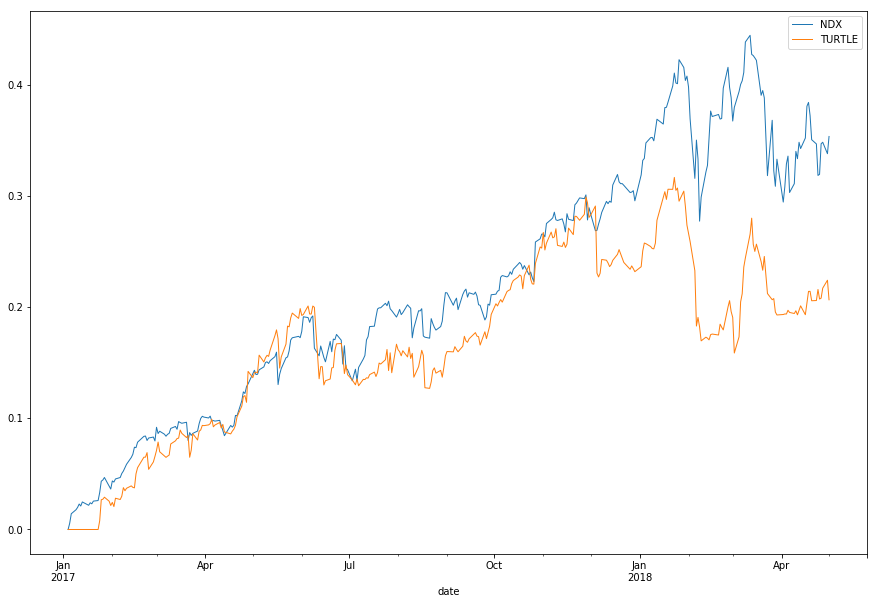

In [11]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = show_df.dropna(how='any', inplace=False).copy()

# fc = df.iloc[0]['close']
# df.loc[:, ['close']]

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
df['PROPERTY_T'] = (df['PROPERTY_T'] - df.iloc[0]['PROPERTY_T']) / df.iloc[0]['PROPERTY_T']
# df['CASH_T'] = (df['CASH_T'] - df.head(1)['CASH_T'].values) / df.head(1)['PROPERTY_T'].values

ax = df.plot(kind='line', y='close', label='NDX', linewidth=1)
ax = df.plot(kind='line', y='PROPERTY_T', secondary_y=False, label='TURTLE', linewidth=1, ax=ax)
# ax = df.plot(kind='line', y='CASH_T', secondary_y=True, label='TURTLE_CASH_T', linewidth=1, ax=ax)

# for symbol, stock_df in stock_df_dict.items():
#     df = stock_df.copy()
#     df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
#     ax = df.plot(kind='line', y='close', secondary_y=False, label=symbol, linewidth=0.5, ax=ax)

# plt.figure(figsize=(10, 6), dpi=80)
# plt.show()